In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

In [2]:
os.chdir('/Users/gaoteng/Desktop/dataOpen')

In [4]:
delays = pd.read_csv('flight_traffic_head.csv')

In [5]:
delays

,year,month,day,airline_id,origin_airport,destination_airport,scheduled_departure,actual_departure,taxi_out,wheels_off,...,cancelled,diverted,scheduled_elapsed,actual_elapsed,distance,airline_delay,weather_delay,air_system_delay,security_delay,aircraft_delay
0,2017,1,17,AA,CLT,PHX,1619,1616.0,17.0,1633.0,...,0.0,0.0,277.0,266.0,1773.0,NaN,NaN,NaN,NaN,NaN
1,2017,1,18,AA,CLT,PHX,1619,1614.0,13.0,1627.0,...,0.0,0.0,277.0,247.0,1773.0,NaN,NaN,NaN,NaN,NaN
2,2017,1,19,AA,CLT,PHX,1619,1611.0,17.0,1628.0,...,0.0,0.0,277.0,255.0,1773.0,NaN,NaN,NaN,NaN,NaN
3,2017,1,20,AA,CLT,PHX,1619,1656.0,18.0,1714.0,...,0.0,0.0,277.0,273.0,1773.0,33.0,0.0,0.0,0.0,0.0
4,2017,1,21,AA,CLT,PHX,1619,1632.0,17.0,1649.0,...,0.0,0.0,277.0,266.0,1773.0,NaN,NaN,NaN,NaN,NaN
5,2017,1,22,AA,CLT,PHX,1619,1636.0,27.0,1703.0,...,0.0,0.0,277.0,285.0,1773.0,0.0,0.0,8.0,0.0,17.0
6,2017,1,23,AA,CLT,PHX,1619,1616.0,20.0,1636.0,...,0.0,0.0,277.0,291.0,1773.0,NaN,NaN,NaN,NaN,NaN
7,2017,1,24,AA,CLT,PHX,1619,1619.0,18.0,1637.0,...,0.0,0.0,277.0,285.0,1773.0,NaN,NaN,NaN,NaN,NaN
8,2017,1,25,AA,CLT,PHX,1619,1616.0,23.0,1639.0,...,0.0,0.0,277.0,290.0,1773.0,NaN,NaN,NaN,NaN,NaN
9,2017,1,26,AA,CLT,PHX,1619,1618.0,11.0,1629.0,...,0.0,0.0,277.0,284.0,1773.0,NaN,NaN,NaN,NaN,NaN


In [10]:
df = delays[['year', 'month', 'day', 'origin_airport', 'origin_airport', 'scheduled_departure']]
df['length_delay'] = delays.actual_elapsed - delays.scheduled_elapsed
df['stall_delay'] = delays.actual_departure - delays.scheduled_departure
df['total_delay'] = df.length_delay + df.stall_delay

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [11]:
df

,year,month,day,origin_airport,origin_airport,scheduled_departure,length_delay,stall_delay,total_delay
0,2017,1,17,CLT,CLT,1619,-11.0,-3.0,-14.0
1,2017,1,18,CLT,CLT,1619,-30.0,-5.0,-35.0
2,2017,1,19,CLT,CLT,1619,-22.0,-8.0,-30.0
3,2017,1,20,CLT,CLT,1619,-4.0,37.0,33.0
4,2017,1,21,CLT,CLT,1619,-11.0,13.0,2.0
5,2017,1,22,CLT,CLT,1619,8.0,17.0,25.0
6,2017,1,23,CLT,CLT,1619,14.0,-3.0,11.0
7,2017,1,24,CLT,CLT,1619,8.0,0.0,8.0
8,2017,1,25,CLT,CLT,1619,13.0,-3.0,10.0
9,2017,1,26,CLT,CLT,1619,7.0,-1.0,6.0


In [ ]:
df['']

In [32]:
df = df[~np.isnan(df['total_delay'])]

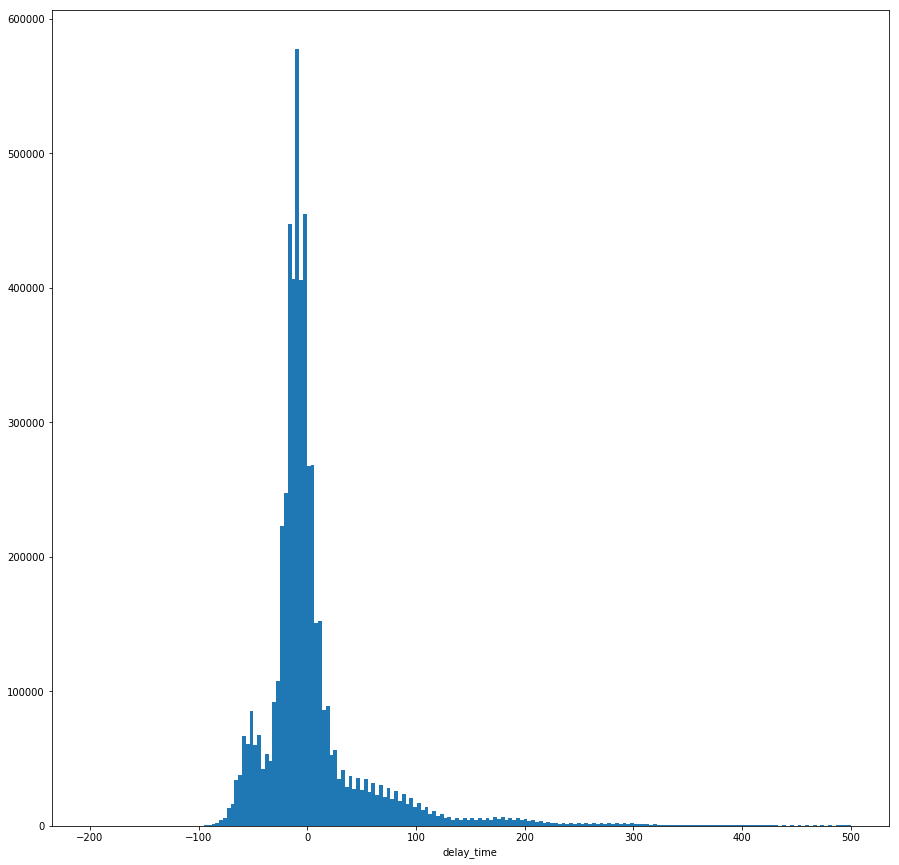

In [47]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.hist(df.total_delay, bins = 200, range=[-200, 500])
ax.set_xlabel('delay_time')

0           -3.0
1           -5.0
2           -8.0
3           37.0
4           13.0
5           17.0
6           -3.0
7            0.0
8           -3.0
9           -1.0
10          -6.0
11          -5.0
12          -8.0
13          -5.0
14          -4.0
15           0.0
16         -49.0
17           7.0
18           9.0
19          -1.0
20         -46.0
21          -2.0
22           9.0
23          45.0
24          -4.0
25         -50.0
26          -4.0
27           4.0
28          -2.0
29          -6.0
           ...  
5674591     11.0
5674592     -5.0
5674593     -8.0
5674594    -10.0
5674595     -4.0
5674596     -1.0
5674597    207.0
5674598      2.0
5674599     -1.0
5674600    393.0
5674601     12.0
5674602     -5.0
5674603    -48.0
5674604     -6.0
5674605     -3.0
5674606     -3.0
5674607     -4.0
5674608      0.0
5674609     -7.0
5674610     -6.0
5674611     -8.0
5674612     -7.0
5674613      2.0
5674614      0.0
5674615     -8.0
5674616     -3.0
5674617     -6.0
5674618     -6